In [ ]:
import nltk
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import BlanklineTokenizer
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
import string
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from multiprocessing import Pool

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
from google.colab import files

In [ ]:
# ambil json api
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
# copy json lalu ngatur permission
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c bootcamp-gemastik-2023-part-2

  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 130MB/s]


In [ ]:
!unzip /content/bootcamp-gemastik-2023-part-2.zip -d /content/latianGemas/

Archive:  /content/bootcamp-gemastik-2023-part-2.zip
  inflating: /content/latianGemas/sample.csv  
  inflating: /content/latianGemas/test.txt  
  inflating: /content/latianGemas/train.txt  


In [ ]:
with open('/content/latianGemas/train.txt', 'r', encoding='utf-8') as train_file:
    train_lines = train_file.readlines()
with open('/content/latianGemas/test.txt', 'r', encoding='utf-8') as test_file:
    test_lines = test_file.readlines()

In [ ]:
def process_data(lines):
    data = []
    for line in lines:
        fields = line.strip().split('\t')
        data.append(fields)
    return data

train_data = process_data(train_lines)
test_data = process_data(test_lines)

# Buat DataFrame untuk data pelatihan dan uji
train_df = pd.DataFrame(train_data, columns=['id', 'tweet', 'emotion', 'score'])
test_df = pd.DataFrame(test_data, columns=['id', 'tweet', 'emotion'])


In [ ]:
train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

In [ ]:
df_train = pd.read_csv('/content/train.csv')
df_train.head()

,id,tweet,emotion,score
0,id,tweet,emotion,score
1,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
2,10001,So my Indian Uber driver just called someone t...,anger,0.896
3,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
4,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896


In [ ]:
# Menghapus baris pertama (indeks 0)
df_train = df_train.iloc[1:]

# Setel ulang indeks jika perlu
df_train = df_train.reset_index(drop=True)

# Menyimpan DataFrame yang telah diubah
df_train.to_csv('df_train.csv', index=False)

In [ ]:
train = pd.read_csv('/content/df_train.csv')
train.tail()

,id,tweet,emotion,score
3608,40781,@VivienLloyd Thank you so much! Just home - st...,sadness,0.104
3609,40782,Just put the winter duvet on ☃️❄️🌬☔️,sadness,0.104
3610,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness,0.088
3611,40784,@BluesfestByron second artist announcement loo...,sadness,0.083
3612,40785,I can literally eat creamy pesto pasta topped ...,sadness,0.083


In [ ]:
train.emotion.value_counts()

fear       1147
anger       857
joy         823
sadness     786
Name: emotion, dtype: int64

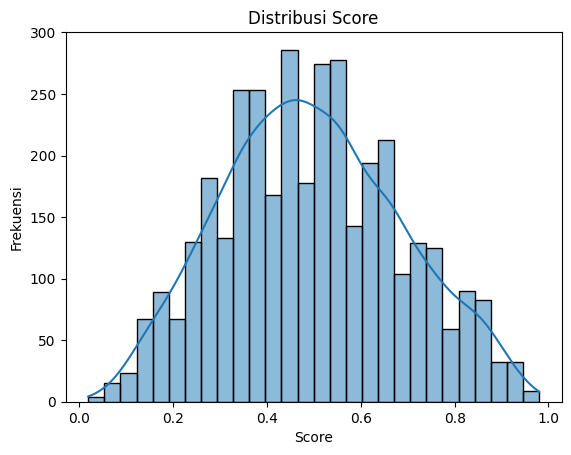

In [ ]:
sns.histplot(train['score'], kde=True)
plt.xlabel('Score')
plt.ylabel('Frekuensi')
plt.title('Distribusi Score')
plt.show()

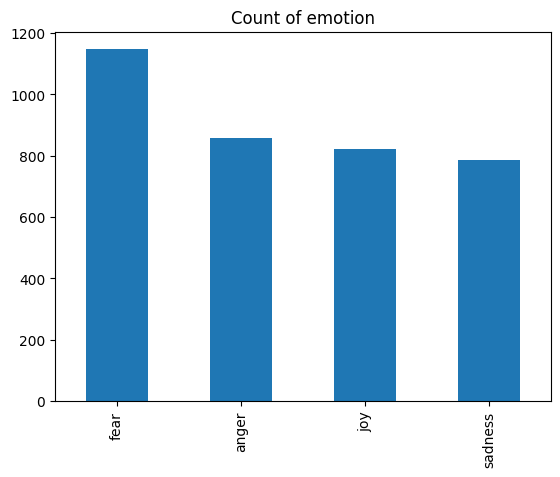

In [ ]:
train.emotion.value_counts().plot(kind='bar', title = "Count of emotion");

In [ ]:
# summary table function
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['%missing'] = df.isnull().sum().values / len(df)* 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    return summ

In [ ]:
summary(train)

data shape: (3613, 4)


,data type,#missing,%missing,#unique
id,int64,0,0.0,3613
tweet,object,0,0.0,3565
emotion,object,0,0.0,4
score,float64,0,0.0,403


# Text preprocessing


In [ ]:
test = pd.read_csv('/content/test.csv')
test.tail()

,id,tweet,emotion
3138,41528,Why does Candice constantly pout #GBBO 💄😒,sadness
3139,41529,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness
3140,41530,"@AceOperative789 no pull him afew weeks ago, s...",sadness
3141,41531,I'm buying art supplies and I'm debating how s...,sadness
3142,41532,@sainsburys Could you ask your Chafford Hundre...,sadness


### Simply Cleaning

In [ ]:
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower() #Convert strings in the Series/Index to lowercase.

    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    #remove url
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"https?://\S+|www\.\S+", "", elem))
    #remove HTML tags
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"<.*?>", "", elem))
    #remove emojis
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", "", elem))
    return df
data_clean = clean_text(train, 'tweet', 'text_clean')
data_clean_test = clean_text(test,'tweet', 'text_clean')
data_clean.head()

,id,tweet,emotion,score,text_clean
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,how the fu*k! who the heck! moved my fridge!.....
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,so my indian uber driver just called someone t...
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,@dpd_uk i asked for my parcel to be delivered ...
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,so ef whichever butt wipe pulled the fire alar...
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,don't join @btcare they put the phone down on ...


### Remove stopwords

In [ ]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data_clean['text_clean'] = data_clean['text_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

,id,tweet,emotion,score,text_clean
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,fu*k! heck! moved fridge!... knock landlord do...
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,indian uber driver called someone n word. movi...
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,@dpd_uk asked parcel delivered pick store addr...
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,ef whichever butt wipe pulled fire alarm davis...
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,"join @btcare put phone you, talk rude. taking ..."


### Tokenizing

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
data_clean['text_tokens'] = data_clean['text_clean'].apply(lambda x: word_tokenize(x))
data_clean.head()

,id,tweet,emotion,score,text_clean,text_tokens
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,fu*k! heck! moved fridge!... knock landlord do...,"[fu, *, k, !, heck, !, moved, fridge, !, ..., ..."
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,indian uber driver called someone n word. movi...,"[indian, uber, driver, called, someone, n, wor..."
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,@dpd_uk asked parcel delivered pick store addr...,"[@, dpd_uk, asked, parcel, delivered, pick, st..."
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,ef whichever butt wipe pulled fire alarm davis...,"[ef, whichever, butt, wipe, pulled, fire, alar..."
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,"join @btcare put phone you, talk rude. taking ...","[join, @, btcare, put, phone, you, ,, talk, ru..."


### Lemmatization

In [ ]:
from nltk.stem import WordNetLemmatizer
def word_lemmatizer(text):
    lem_text = [WordNetLemmatizer().lemmatize(i) for i in text]
    return lem_text
data_clean['text_clean_tokens'] = data_clean['text_tokens'].apply(lambda x: word_lemmatizer(x))
data_clean.head()

,id,tweet,emotion,score,text_clean,text_tokens,text_clean_tokens
0,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938,fu*k! heck! moved fridge!... knock landlord do...,"[fu, *, k, !, heck, !, moved, fridge, !, ..., ...","[fu, *, k, !, heck, !, moved, fridge, !, ..., ..."
1,10001,So my Indian Uber driver just called someone t...,anger,0.896,indian uber driver called someone n word. movi...,"[indian, uber, driver, called, someone, n, wor...","[indian, uber, driver, called, someone, n, wor..."
2,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896,@dpd_uk asked parcel delivered pick store addr...,"[@, dpd_uk, asked, parcel, delivered, pick, st...","[@, dpd_uk, asked, parcel, delivered, pick, st..."
3,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896,ef whichever butt wipe pulled fire alarm davis...,"[ef, whichever, butt, wipe, pulled, fire, alar...","[ef, whichever, butt, wipe, pulled, fire, alar..."
4,10004,Don't join @BTCare they put the phone down on ...,anger,0.896,"join @btcare put phone you, talk rude. taking ...","[join, @, btcare, put, phone, you, ,, talk, ru...","[join, @, btcare, put, phone, you, ,, talk, ru..."


In [ ]:
data_clean_test

,id,tweet,emotion,text_clean
0,id,tweet,emotion,tweet
1,10941,At the point today where if someone says somet...,anger,at the point today where if someone says somet...
2,10942,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger,@corningfootball it's game day!!!! t min...
3,10943,This game has pissed me off more than any othe...,anger,this game has pissed me off more than any othe...
4,10944,@spamvicious I've just found out it's Candice ...,anger,@spamvicious i've just found out it's candice ...
...,...,...,...,...
3138,41528,Why does Candice constantly pout #GBBO 💄😒,sadness,why does candice constantly pout #gbbo
3139,41529,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness,"@redbus_in #unhappy with #redbus cc, when i ta..."
3140,41530,"@AceOperative789 no pull him afew weeks ago, s...",sadness,"@aceoperative no pull him afew weeks ago, sadl..."
3141,41531,I'm buying art supplies and I'm debating how s...,sadness,i'm buying art supplies and i'm debating how s...


In [ ]:
# Menghapus baris pertama (indeks 0)
data_clean_test = data_clean_test.iloc[1:]

# Setel ulang indeks jika perlu
data_clean_test = data_clean_test.reset_index(drop=True)

In [ ]:
data_clean_test.shape

(3142, 4)

# Data splitting

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data_clean['text_clean'],

                                                    data_clean['score'],
                                                    test_size = 0.2,
                                                    random_state = 10)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(2890,)
(723,)
(2890,)
(723,)


In [ ]:
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(),
            index=['sentence '+str(i)
                   for i in range(1, 1+len(X_train))],
            columns=vectorizer.get_feature_names_out())

,__,___,__dayo,__kirstyga,__peterpanda,_aleix,_full_plus_by_gora,_indubioproreo,_inferno_,_j_sa_,...,zone,zoolander,ztoronto,zumba,деньги,الخفجي,اليوم_الوطني,ध_य,य_ब,सत
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 2886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Only alphabet, contains at least 3 letters
vectorizer = CountVectorizer(analyzer='word',
                              token_pattern=r'\b[a-zA-Z]{3,}\b',
                              ngram_range=(1, 1))
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(),
             index=['sentence '+str(i)
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names_out())

,aaa,aajtak,aaron,aaronbiggspro,aarongoodwin,aateam,abby,abc,abcdesignated,aber,...,zika,zilch,zionist,zombie,zombiecalorie,zombies,zone,zoolander,ztoronto,zumba
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 2886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
vectorizer = CountVectorizer(analyzer='word',
                              token_pattern=r'\b[a-zA-Z]{3,}\b',
                              ngram_range=(2, 2))  # only bigrams
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(),
             index=['sentence '+str(i)
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names_out())

,aaa cam,aajtak timesnow,aaron beck,aaronbiggspro wwenowayjose,aarongoodwin seriously,aateam horrible,abby way,abc cares,abc nra,abcdesignated opened,...,zombie gore,zombie rage,zombie would,zombiecalorie sensing,zombies angels,zone ngo,zoolander hilarious,zoolander samvrhys,ztoronto podcasts,zumba piyo
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 2886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# consider both unigrams and bigrams, occur at least twice
vectorizer = CountVectorizer(analyzer='word',
                              token_pattern=r'\b[a-zA-Z]{3,}\b',
                              ngram_range=(1, 2),                                             min_df = 2)
vectorized = vectorizer.fit_transform(X_train)
pd.DataFrame(vectorized.toarray(),
             index=['sentence '+str(i)
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names_out())

,aateam,abc,abcdesignated,abcdesignated opened,aberdeen,aberdeen johnstone,ability,ability process,able,abortion,...,zero help,zero results,zika,zika hoax,zombie,zombiecalorie,zombiecalorie sensing,zoolander,ztoronto,ztoronto podcasts
sentence 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 2886,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
sentence 2889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.feature_extraction.text import (CountVectorizer,
                                             TfidfVectorizer,
                                             TfidfTransformer)
vectorizer = CountVectorizer(analyzer='word',
                              token_pattern=r'\b[a-zA-Z]{3,}\b',
                              ngram_range=(1, 1)
                              )
count_vectorized = vectorizer.fit_transform(X_train)
tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
train_features = tfidf.fit_transform(count_vectorized).toarray()

pd.DataFrame(train_features,
             index=['sentence '+str(i)
                    for i in range(1, 1+len(X_train))],
             columns=vectorizer.get_feature_names_out())

,aaa,aajtak,aaron,aaronbiggspro,aarongoodwin,aateam,abby,abc,abcdesignated,aber,...,zika,zilch,zionist,zombie,zombiecalorie,zombies,zone,zoolander,ztoronto,zumba
sentence 1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2,0.435333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 2886,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2887,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2888,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2889,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Convert a collection of text documents to a matrix of token counts
tfidf = feature_extraction.text.TfidfVectorizer(encoding='utf-8',
                       ngram_range=(1,1),
                       max_features=5000,
                       norm='l2',
                       sublinear_tf=True)

In [ ]:
train_features = tfidf.fit_transform(X_train).toarray()

In [ ]:
pd.DataFrame(train_features,
             index=['sentence '+str(i)
                    for i in range(1, 1+len(X_train))],
             columns=tfidf.get_feature_names_out())

,__,__kirstyga,aateam,abc,abcdesignated,aberdeen,ability,able,abortion,about,...,zavvihelp,zero,zika,zombie,zombiecalorie,zoolander,ztoronto,ध_य,य_ब,सत
sentence 1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentence 2886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
sentence 2889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_features = tfidf.transform(X_test).toarray()
print(test_features.shape)

(723, 5000)


In [ ]:
train_labels = Y_train
test_labels = Y_test

# Modeling

In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.5 MB/s eta 0:00:00


In [ ]:
import optuna
import xgboost as xgb

In [ ]:
# # Inisialisasi model Xgboost baseline
# xgb_model = xgb.XGBRegressor()

# # Melatih model dengan data pelatihan
# xgb_model.fit(train_features, train_labels)

In [ ]:
# import lightgbm as lgb
# from lightgbm import LGBMRegressor

# # Buat model LGBMRegressor
# lgbm_model = LGBMRegressor(
#     boosting_type='gbdt',
#     num_leaves=31,
#     learning_rate=0.05,
#     n_estimators=100,
#     random_state=42
# )

# # Latih model pada data pelatihan
# lgbm_model.fit(train_features, train_labels)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2798
[LightGBM] [Info] Number of data points in the train set: 2890, number of used features: 201
[LightGBM] [Info] Start training from score 0.495161


LGBMRegressor(learning_rate=0.05, random_state=42)

In [ ]:
def objective(trial):

    n_estimators = trial.suggest_int("n_estimators", 1000, 5000)
    max_depth = trial.suggest_int("max_depth", 1, 10)
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-1, log=True)
    gamma = trial.suggest_float("gamma", 0.1, 1.0, step=0.1)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 7, step=2)
    subsample = trial.suggest_float("subsample", 0.5, 1.0, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0, step=0.1)
    reg_alpha = trial.suggest_float("reg_alpha", 0., 1.0, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 0., 1.0, step=0.1)
    seed = trial.suggest_int("random_state", 20, 50, step=2)


    model = xgb.XGBRegressor(n_estimators=n_estimators,
                                max_depth=max_depth,
                                learning_rate=learning_rate,
                                gamma=gamma,
                                min_child_weight=min_child_weight,
                                colsample_bytree=colsample_bytree,
                                subsample=subsample,
                                reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                n_jobs=-1, metric=mean_squared_error,
                                eval_metric=mean_squared_error,
                                random_state=seed
                                )

    model.fit(train_features, train_labels)

study = optuna.create_study()
study.optimize(objective, n_trials=50)

# Menggunakan parameter terbaik yang ditemukan untuk melatih model dan melakukan prediksi
best_params = study.best_params
best_model = XGBRegressor(**best_params, n_jobs=-1, random_state=seed)

[I 2023-09-09 05:51:54,987] A new study created in memory with name: no-name-3d0bd8c7-b565-46d3-938b-9348db8f9139
[W 2023-09-09 06:00:52,454] Trial 0 failed with parameters: {'n_estimators': 3229, 'max_depth': 3, 'learning_rate': 2.2772560394584025e-06, 'gamma': 0.7000000000000001, 'min_child_weight': 1, 'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 0.4, 'reg_lambda': 0.9, 'random_state': 48} because of the following error: The value None could not be cast to float..
[W 2023-09-09 06:00:52,456] Trial 0 failed with value None.
[W 2023-09-09 06:10:56,640] Trial 1 failed with parameters: {'n_estimators': 2818, 'max_depth': 3, 'learning_rate': 1.9526942472310555e-05, 'gamma': 0.7000000000000001, 'min_child_weight': 3, 'subsample': 0.5, 'colsample_bytree': 0.8, 'reg_alpha': 0.2, 'reg_lambda': 0.2, 'random_state': 28} because of the following error: The value None could not be cast to float..
[W 2023-09-09 06:10:56,642] Trial 1 failed with value None.


In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
best_model.fit(train_features, train_labels)

# Test Cleaning

In [ ]:
test_vectorizer =tfidf.transform( data_clean_test['text_clean']).toarray()

In [ ]:
test_vectorizer.shape

(3142, 5000)

In [ ]:
final_predictions = best_model.predict(test_vectorizer)

In [ ]:
submission_df = pd.read_csv('/content/latianGemas/sample.csv')

In [ ]:
submission_df['id'] = data_clean_test['id']
submission_df['score'] = final_predictions

In [ ]:
submission_df

,id,score
0,10941,0.468079
1,10942,0.383709
2,10943,0.423273
3,10944,0.471036
4,10945,0.490611
...,...,...
3137,41528,0.470034
3138,41529,0.639957
3139,41530,0.432600
3140,41531,0.352760


In [ ]:
submission = submission_df.to_csv('Resultlgbm.csv',index = False)